In [13]:
import jax.numpy as jnp
import jax
from numpyro.infer import NUTS, MCMC
import matplotlib.pyplot as plt
import seaborn as sns

from experiments.targets import BLR
from projection_vi.flows import ComponentwiseFlow, AffineFlow
from projection_vi.train import train, iterative_AS_mfvi
from projection_vi.utils import softplus, inverse_softplus

In [3]:
# set up target distribution
n = 20
d = 10

key = jax.random.key(2025)
cov_X = jnp.logspace(-1, 1, d)
key, subkey = jax.random.split(key)
U_ = jnp.linalg.qr(jax.random.normal(subkey, shape=(d, d)))[0]
cov_X = U_ @ jnp.diag(cov_X) @ U_.T
key, subkey = jax.random.split(key)
X = jax.random.multivariate_normal(subkey, mean=jnp.zeros(d), cov=cov_X, shape=(n,))

key, subkey = jax.random.split(key)
y = jax.random.bernoulli(subkey)

prior_scale = 2.

target = BLR(X, y, prior_scale=prior_scale)

## Run MCMC

In [4]:
num_warmup = 100
num_samples = 6000
num_chains = 1
thinning = 2

nuts_kernel = NUTS(target.numpyro_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, thinning=thinning)
mcmc.run(jax.random.key(0))

mcmc_samples = mcmc.get_samples()

param_names = target.param_unc_names()
samples_unc = None
for key in param_names:
    sample = mcmc_samples[key]
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)
    if samples_unc is None:
        samples_unc = sample
    else:
        samples_unc = jnp.concatenate([samples_unc, sample], axis=1)

mcmc_samples = target.param_constrain(samples_unc)
mcmc_samples = mcmc_samples.reshape(-1, d)

sample: 100%|██████████| 6100/6100 [00:01<00:00, 3160.77it/s, 15 steps of size 2.28e-01. acc. prob=0.93]


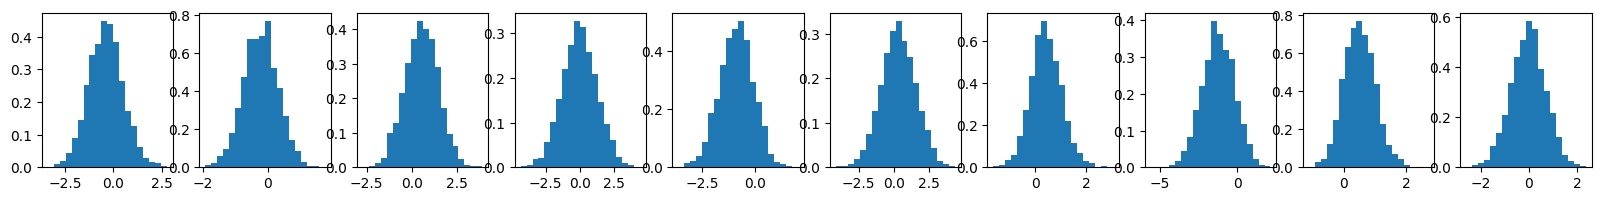

In [5]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 20, density=True)

## Initialize with MF Gaussian

In [6]:
@jax.jit
def logp_fn(x):
    return target.log_prob(x)

learning_rate = 1e-2
max_iter = 1000
n_train = 3000
n_val = 1000
key, subkey = jax.random.split(jax.random.key(0))
base_samples = jax.random.normal(subkey, (n_train + n_val, d))
val_samples = base_samples[n_train:]
base_samples = base_samples[:n_train]

affine_model = AffineFlow(d=d)
affine_params = affine_model.init(jax.random.key(0), jnp.zeros((1, d)))
@jax.jit
def loss_fn(affine_params):
    return affine_model.apply(affine_params, base_samples, logp_fn, method=affine_model.reverse_kl)
affine_params, losses = train(loss_fn, affine_params, learning_rate=learning_rate, max_iter=max_iter)

shift = affine_params['params']['shift']
scale = softplus(affine_params['params']['scale_logit'] + inverse_softplus(1.))

@jax.jit
def logp_fn_shifted(x):
    return logp_fn(x * scale + shift) + jnp.sum(jnp.log(scale))

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 3592.62it/s]


## Training

Perform one iteration of MFVI, with different rotations:

- No rotation
- Random rotation
- Active subspace rotation

In [8]:
model = ComponentwiseFlow(d=d, num_bins=15, range_min=-8, range_max=8)
niter = 1

# no rotation; MFVI
key, subkey = jax.random.split(key)
mf_samples, mf_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=-1, rank=0, weighted=False)

# random rotation
key, subkey = jax.random.split(key)
RP_samples, RP_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=0, rank=0, weighted=False)

# active subspace rotation
key, subkey = jax.random.split(key)
AS_samples, AS_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=1, rank=d, weighted=False)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:03<00:00, 282.62it/s]


Iteration: 0 KL: 28.17715 ESS: 3.194341


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:03<00:00, 322.12it/s]


Iteration: 0 KL: 27.60854 ESS: 5.3511877


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:02<00:00, 335.09it/s]


First 8 components explain 0.96800005 of variance
Iteration: 0 KL: 25.430822 ESS: 62.36684


In [9]:
def make_histogram(samples):
    samples_constrain = samples * scale + shift
    _, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
    for j in range(min(d, 10)):
        ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=.5)
        ax[j].hist(samples_constrain[:, j], 30, density=True, alpha=.5)

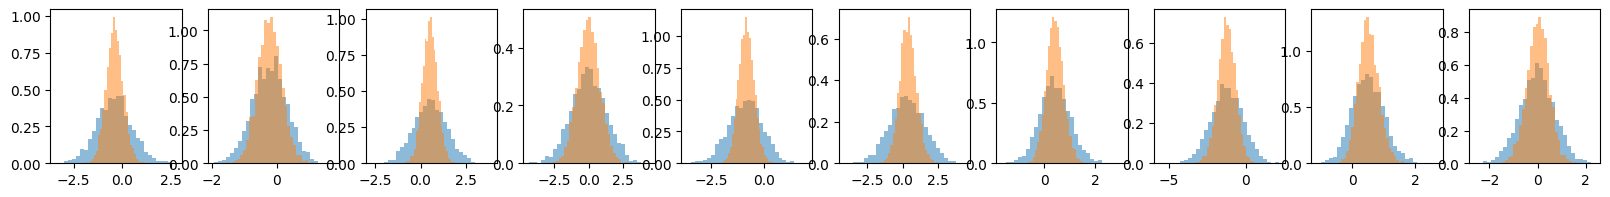

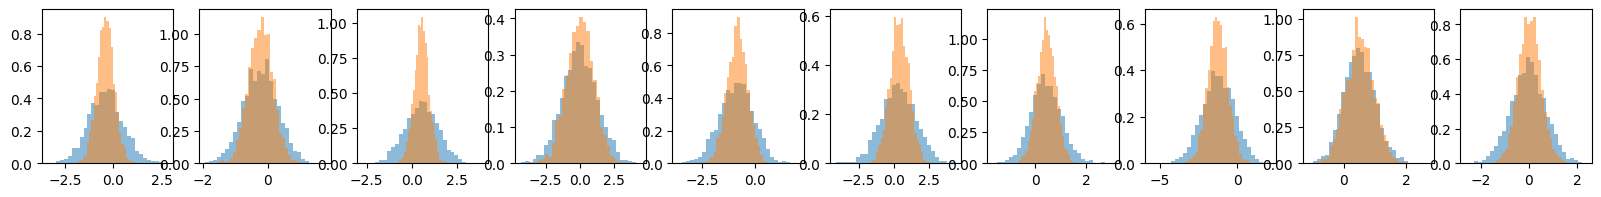

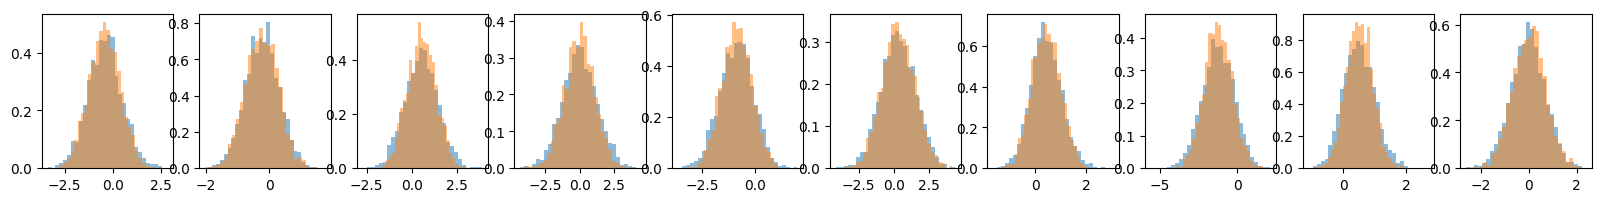

In [10]:
make_histogram(mf_samples[0])
make_histogram(RP_samples[0])
make_histogram(AS_samples[0])

In [11]:
def make_scatter_plot(ax, samples):
    samples_constrain = samples * scale + shift
    ax.scatter(mcmc_samples[:, 0], mcmc_samples[:, 2], marker='o', alpha=0.5, label='MCMC')
    ax.scatter(samples_constrain[:, 0], samples_constrain[:, 2], marker='o', alpha=0.5, label='NF')

Text(0.5, 1.0, 'Active subspace')

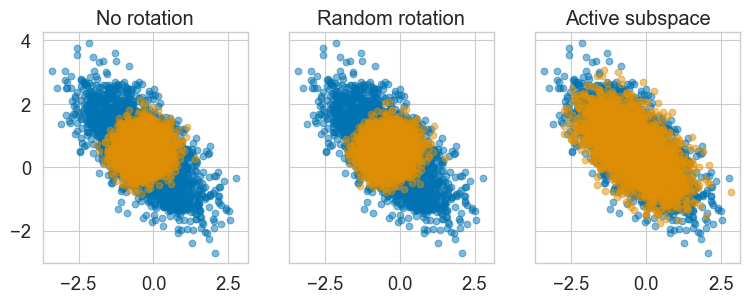

In [12]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5, palette='colorblind')

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
make_scatter_plot(ax[0], mf_samples[0])
make_scatter_plot(ax[1], RP_samples[0])
make_scatter_plot(ax[2], AS_samples[0])

ax[0].set_title('No rotation')
ax[1].set_title('Random rotation')
ax[2].set_title('Active subspace')